# Programmentwurf Data Science
#### Ilvy Schulz und Pia Skuthan

In [11]:
# Alle Importe der Datei - bitte zum Anfang einmal ausführen
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

## 1. Data Understanding - Test

Zuerst werden die Daten aus der Datei eingelesen und anschließend wird die Form überprüft.
So kann sicher gestellt werden, dass die Daten richtig eingelesen werden und, wie vorgegeben, die Form (128, 128 191) besitzt.

In [12]:
ims_cube = scipy.io.loadmat("ims_cube.mat")["ims_cube"]
ims_cube.shape

(128, 128, 191)

Um die räumliche Verteilung einzelner Features des Datensatzes zu untersuchen, werden exemplarisch acht Kanäle aus dem Spektralbereich ausgewählt.
Da die Daten 191 spektrale Kanäle (0–190) umfassen, werden die Features in 25er-Schritten gewählt, um eine gleichmäßige Verteilung über das gesamte Spektrum zu erhalten und verschiedene Bereiche der Daten zu betrachten. Um die räumliche Verteilung möglichst erkennbar zu machen, wird hier die Color Map "Jet" genutzt, die auch kleine Änderungen deutlich sichtbar macht.

Hier fällt auch auf, dass einige Features (wie 140 oder 190) nicht existieren bzw. der plot nur einfarbig ist und keine räumliche Verteilung aufweist. Diese Features wurden absichtlich nicht geplottet, da man keinerlei weitere Informationen aus diesen Verteilungen ziehen kann.

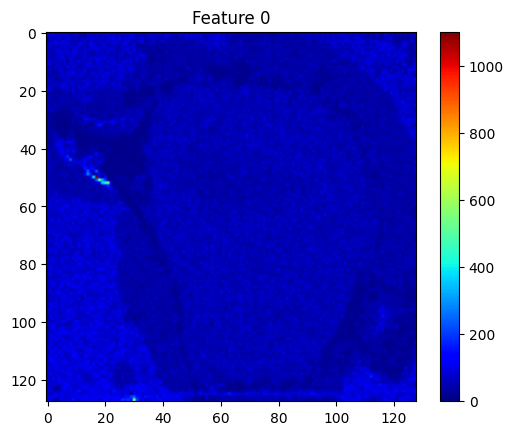

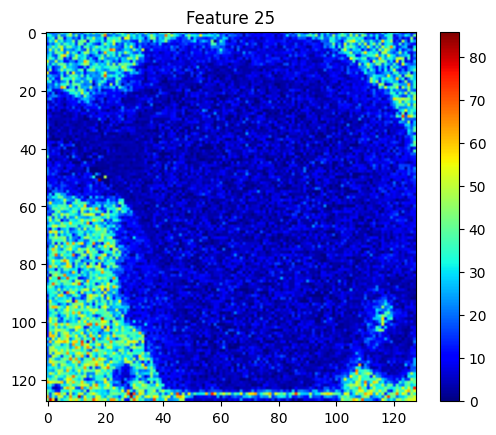

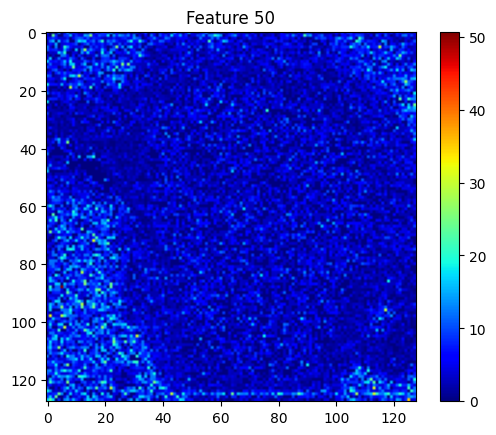

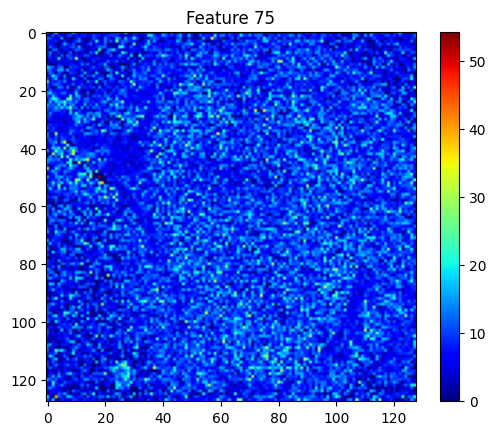

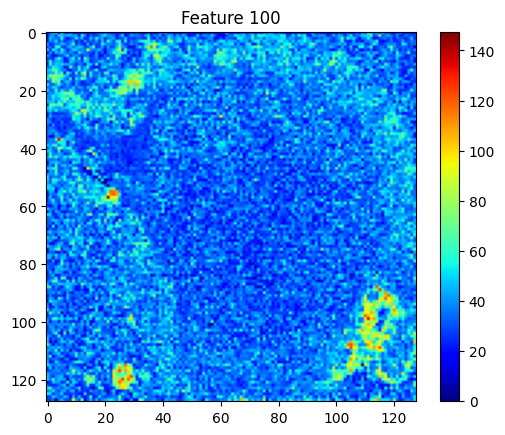

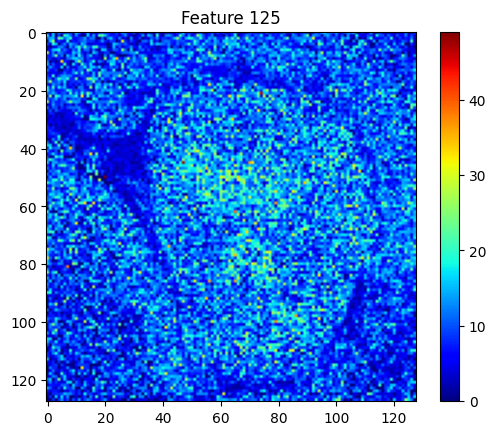

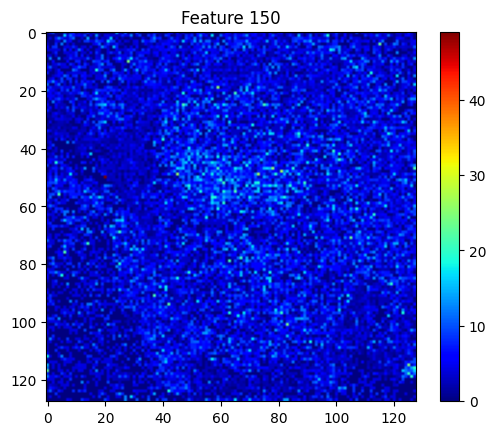

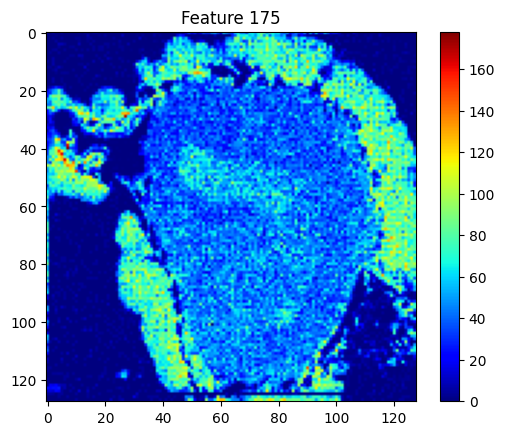

In [13]:
for i in range(0,190,25):
    plt.imshow(ims_cube[:, :, i], cmap='jet')
    plt.title(f"Feature {i}")
    plt.colorbar()
    plt.show()

Nun werden einmal einige Spektren in einem Diagramm aufgezeigt. Es werden hier schon einige Überlappende Feautures deutlich, um die Intensität der Features im gesamten noch einmal zu sehen, wurde anschließend einmal ein mittleres Spektrum der Daten visualisiert.

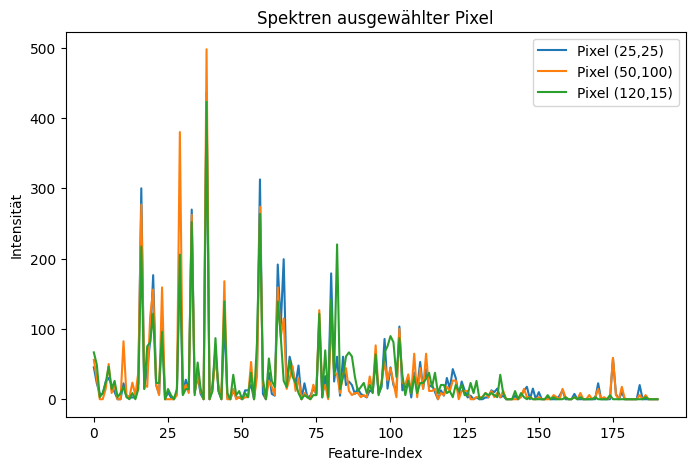

In [14]:
pixel_coords = [(25, 25), (50, 100), (120, 15)]

plt.figure(figsize=(8, 5))

for (x, y) in pixel_coords:
    spectrum = ims_cube[x, y, :]
    plt.plot(range(ims_cube.shape[2]), spectrum, label=f'Pixel ({x},{y})')

plt.xlabel('Feature-Index')
plt.ylabel('Intensität')
plt.title('Spektren ausgewählter Pixel')
plt.legend()
plt.show()

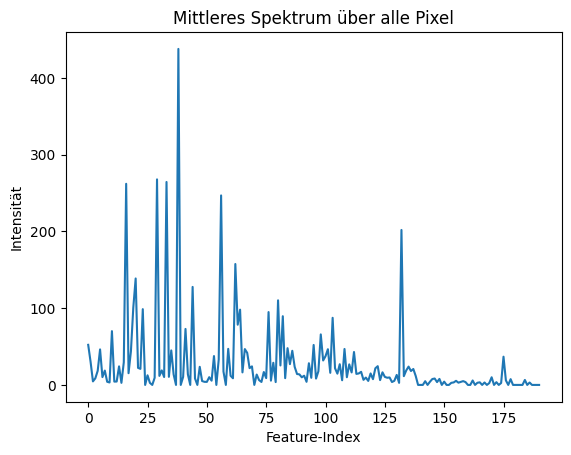

In [15]:
mean_spectrum = ims_cube.mean(axis=(0, 1))
plt.plot(mean_spectrum)
plt.title('Mittleres Spektrum über alle Pixel')
plt.xlabel('Feature-Index')
plt.ylabel('Intensität')
plt.show()

In dem Graphen wird nun deutlich, dass die durschnittliche Intensität bei einzelnen Features deutlich höher ist, also bei anderen. Um die genauen Features herauszufiltern, die deutlich herausstechen, wurde im nachfolgenden mithilfe von Z-Score eine anomaly detection durchgeführt.
Zum anderen fällt hier auch auf, dass die Intensität der ersten 100 Features deutlich höher ist als die der letzten 90.

In [16]:
z_scores = np.abs(stats.zscore(mean_spectrum))
threshold = 2.5
highest_intensity = np.where(z_scores > threshold)[0]

print("Features mit auffällig hoher durchschnittlicher Intensität:\n", highest_intensity)


Features mit auffällig hoher durchschnittlicher Intensität:
 [ 16  29  33  38  56 132]


## 2. Data Preparation für Aufgabe 4


In der Aufgabe 4 werden wir einmal eine Principal Component Analysis (PCA) und dann noch die Non-negative Matrix Factorization (NMF) Methode verwenden. 

Für beides müssen wir den Datensatz aufbreiten. Da wir aus dem 3D Datensatz mit dem "reshape" einen 2D Datensatz generieren müssen, da PCA und NMF mit Tabellen arbeitet. Hätte man die Daten nicht in "D umgewandelt, könnte der Algorithmus später nicht "durch die Pixel gehen" und die Gemeinsamkeiten und Spektren erkennen, da nur im 2D die Rechenoperationen möglich sind.

Die Zeilen sind die Pixel und die Spalten sind die Spektralkanäle:

In [ ]:
X = ims_cube.reshape(-1, ims_cube.shape[2])
print("Form der Datenmatrix:", X.shape)

Form der Datenmatrix: (16384, 191)
Die Daten für PCA sind vorbereitet.


Jetzt müssen die Daten für das PCA standardisiert werden, damit alle Features gleich gewichtet werden.

Dabei wird der Mittelwert jeder Spalte auf 0 gesetzt und die Varianz auf 1 skaliert.

Das sorgt dafür, dass PCA die Varianz um den Ursprung (0) sucht und nicht um einen beliebigen anderen Punkt im Raum.
Die Varianz auf 1 zu setzen ist wichtig, weil dadurch jede Spalte dieselbe Skala erhält und die Werte zwischen den Kanälen vergleichbar werden. So werden alle Spektralkanäle gleich behandelt, und PCA kann echte Muster und Zusammenhänge in den Daten erkennen und dies unabhängig von unterschiedlichen Messbereichen.

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
print("Die Daten für PCA sind vorbereitet.")

Die Daten für PCA sind vorbereitet.


Für die NMF-Methode müssen alle Daten positiv sein, da NMF die Daten als additive Kombination positiver Komponenten beschreibt. Negative Werte würden hier keinen Sinn ergeben, da man keine „negativen Anteile“ von Spektren haben kann.
Damit alle Werte positiv sind, wird der Datensatz so verschoben, dass der kleinste Wert 0 ist:

In [21]:
X_nmf = X - np.min(X)
print("Die Daten für NMF sind vorbereitet.")

Die Daten für NMF sind vorbereitet.
